*updated 05 Aug 2025, Julian Mak (whatever with copyright, do what you want with this)

### As part of material for OCES 4303 "AI and Machine Learning in Marine Science" delivered at HKUST

For the latest version of the material, go to the public facing [GitHub](https://github.com/julianmak/OCES4303_ML_ocean) page.

---
# 5. Classification tasks

So far we have dealt with ***regression***, which we assume the target is continuously varying. ***Classification*** would be the discrete version of that, i.e. predict the discrete labels given the data. Examples of this might be:

* Given attributes from the `penguins` data, predict the species
* Classify whether an image is that of a cat or a dog
* Predicting whether an Argo temperature/sainity profile is from a particular geographical location if I label it accordingly (e.g. from the Atlantic)

We are going to come back to these again when we get to decision trees / random forests, and neural networks (which can also do regression). For now we are introduce some other algorithms for the classification tasks, with some detours that will also be useful later on when we deal with trees and neural networks.

> ## Key Objective(s)
> 1. Understand the difference between regression and classification (they are not that different...)
> 2. Appreciate that classification is closerly related to finding separation between labelled data (and separation again depends on what you mean by distance).
> 3. Introduce other loss functions, some of which are closely related to ***activation functions*** that we will encounter when dealing with neural networks.
> 4. Do some basic classification tasks.

For most of the below I am going to use some artificial data for the code demonstration, before performing similar calculations with the penguins data.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

---
## a) Linear/Quadratic Discriminant Analysis (L/QDA)

The idea of classification is to find a separator between two sets of data, then you can say if my data lies to one side it is class $A$ etc. The main idea of ***LDA*** and ***QDA*** is that you find a linear and quadratic separator between the data. Without going into the subtleties, the two methods here have closed form solutions and no hyperparameters to tune, and are generally quite robust. For some more details, you could start with [here](https://scikit-learn.org/stable/modules/lda_qda.html).

I am going to leverage the moon data for this. The creation mechanism already has spits out the labels (I just happened to suppress it last time); you could have make label yourself through the procedures in the last lecture in principle.

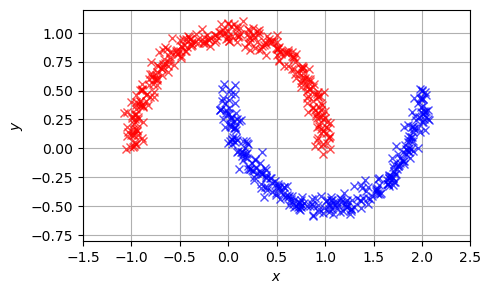

In [2]:
# create moon data, cluster and then label them
from sklearn.datasets import make_moons

# use different colours for reasons later
colors = "rb"  # red blue

n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=0)     # labels are numeric: 0 and 1

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X[Y==i, 0], X[Y==i, 1], f"{colors[i]}x", alpha=0.7)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-0.8, 1.2])
ax.grid();

Going to first demonstrate LDA. We do train/test split, but we don't really need to standarise for this dataset. The predictions return labels, and the check on the score is simply how many labels did it get correct (`np.sum(Y_pred == Y_test)`).

In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# withhold 20% of data that model training does not see, and use that to test skill
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4167)

In [4]:
# fit models
model = LinearDiscriminantAnalysis()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(" ")

overall skill: 106 correct out of 120 (88.33%)
 


We have broad diagnostics of skill but it may be of interest to actually see what is the boundary the model decided to find. Here we can leverage `sklearn.inspection.DecisionBoundaryDisplay` for this purpose.

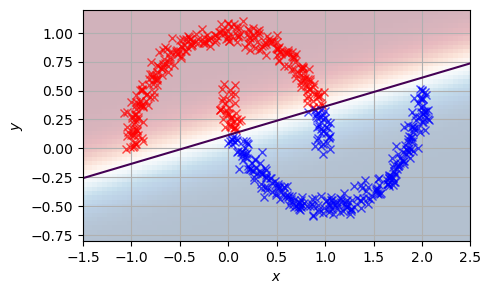

In [5]:
from sklearn.inspection import DecisionBoundaryDisplay

# do a prediction but on full data
Y_pred = model.predict(X)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X[Y_pred==i, 0], X[Y_pred==i, 1], f"{colors[i]}x", alpha=0.7)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict_proba",
    plot_method="pcolormesh",
    ax=ax,
    cmap="RdBu",
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict_proba",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5],  # because the labels are 0 or 1, and (0 + 1)/2 = 0.5
)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-0.8, 1.2])
ax.grid();

So everything above the line is predicted as red and below is blue, and there are some parts of the moon that gets predicted wrong. This is not entirely surprising because for this case there is no linear line in 2d that cuts the data cleanly in half.

Before we move on to QDA, note that you can use LDA as a way to do dimension reduction. For this problem the data is embedded in 2d, so the reduction goes to 1d. Within the lower dimension the idea is to find the best separator, which in this case is some horizontal line. Given the data mixing, there is no clean separation.

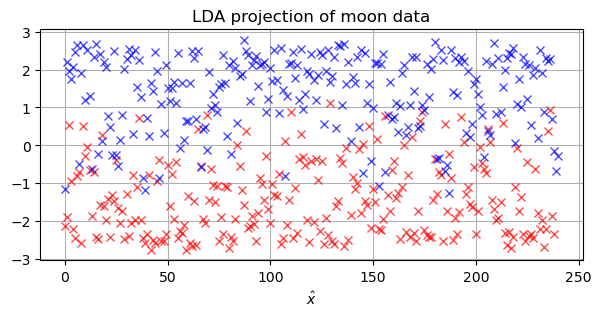

In [6]:
# reduction of dimenion by 1 in this case
X_transform = model.transform(X_train)

# plot out the transforms + projected data with labels
fig = plt.figure(figsize=(7, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X_transform[Y_train == i], f"{colors[i]}x", alpha=0.7)
ax.set_xlabel(r"$\hat{x}$")
ax.set_title(r"LDA projection of moon data")
ax.grid()

A similar thing can be done with QDA, although there is no dimension reduction procedure here with the `sklearn` implementation.

overall skill: 106 correct out of 120 (88.33%)
 


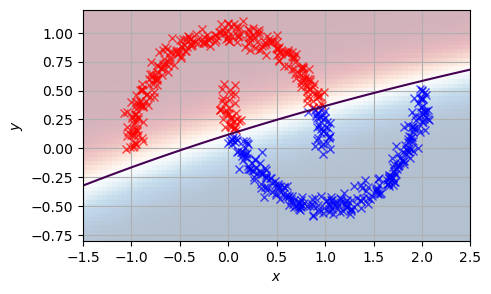

In [7]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

# fit models
model = QuadraticDiscriminantAnalysis()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(" ")

# do a prediction but on full data
Y_pred = model.predict(X)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X[Y_pred==i, 0], X[Y_pred==i, 1], f"{colors[i]}x", alpha=0.7)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict_proba",
    plot_method="pcolormesh",
    ax=ax,
    cmap="RdBu",
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict_proba",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5],  # because the labels are 0 or 1, and (0 + 1)/2 = 0.5
)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-0.8, 1.2])
ax.grid();

Here the boundary is a quadratic curve that gives a marginally better performance than LDA. This is perhaps not surprising because the separator has more complexity and is slightly more flexible.

> <span style="color:red">Q.</span> I didn't standardise the data, and I am fairly sure it doesn't actually do anything for this case. Convince yourself there is some merit in that assertion.
>
> <span style="color:red">Q.</span> Here you probably don't need to check for robustness and cross-validation as such, because the data and the methods are simple enough, but give that a go to see how the prediction scores change.
>
> <span style="color:red">Q.</span> Try something similar for the swiss roll or S curve data embedded in 3d. The way I would do it is "unroll" the data somehow (use a dimension reduction technique to 2d), then artificially draw a line in the plane and call one half something and another half something else. You could also try and have multiple labels (which we will see later with the penguins data).
>
> Note that the `DecisionBoundaryDisplay` routine will complain if the predictor requires more than two inputs (because plotting a surface of separation is hard). You could of course include dimension reduction techniques in the pipeline.

---
## b) Support Vector Machine (SVM)

If we take the moon data example above then you can argue there is no way I can separate the data unless I have enough complexity, which may then give me over-fitting. But that's only if I am stuck 2d; see below for an artificial example.

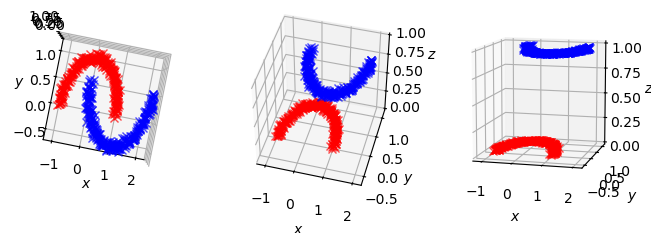

In [8]:
# use different colours for reasons later
colors = "rb"  # red blue

n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=0)     # labels are numeric: 0 and 1

# artificially lift the data into 3d
fig = plt.figure(figsize=(8, 4))

# lift the data into 3d and shift the z-coordinate but some constant
X_3d = np.zeros((X.shape[0], X.shape[1]+1))  # make a bigger array
X_3d[:, :-1] = X                             # dump in the old data
X_3d[:, 2] = np.where(Y==0, 0.0, 1.0)        # add a z-coord related to label

elev_range = [90, 45, 10]
for j in range(3):
    ax = plt.subplot2grid((1, 3), (0, j), projection="3d")
    for i in range(2):
        ax.plot(X_3d[Y==i, 0], X_3d[Y==i, 1], X_3d[Y==i, 2], f"{colors[i]}x", alpha=0.7)
    ax.view_init(azim=-75, elev=elev_range[j])
    ax.set_box_aspect((1, 1, 1))
    ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$"); ax.set_zlabel(r"$z$");

If we do that then the separator is "obvious" to find. You can of course argue that I can arbitrarily promote the data to higher dimensions (effectively as a co-ordinate transformation of course), then I can always find a good separator (i.e. high-dimensional hyperplane) for it.

The idea of ***Support Vector Machine*** (SVM) is essentially to fix a maximal separator between the labelled data, allowing for promotion to higher dimension space, but penalising that latter procedure. The result is again an optimisation problem.

> NOTE: The details are a bit complicated in that you actually solve a ***dual problem*** using the ***kernel trick***. Not going to go into that.

In `sklearn` SVM is in the module `svm`, and we can try and do the above but with default SVM. We are going to use `SVC` which is the basic one for classification. The default there uses the regularisation parameter `C=1` and `kernel=rbf` (Radial Basis Function). Have a look at [here](https://scikit-learn.org/stable/modules/svm.html) to see what those mean.

> NOTE: You can also use SVM for doing regression (`SVR`); see extended exercise later.

overall skill: 120 correct out of 120 (100.00%)


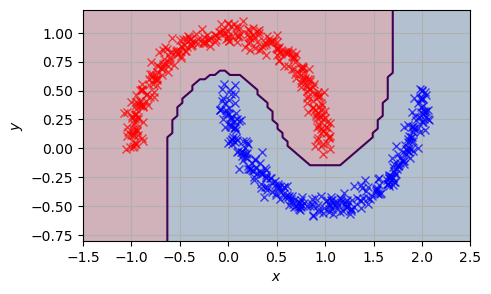

In [9]:
from sklearn import svm

n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=0)     # labels are numeric: 0 and 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4167)

# fit models
model = svm.SVC()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")

# do a prediction but on full data
Y_pred = model.predict(X)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X[Y_pred==i, 0], X[Y_pred==i, 1], f"{colors[i]}x", alpha=0.7)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",  # SVM has no probability associated with predictions
    plot_method="pcolormesh",
    ax=ax,
    cmap="RdBu",
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5],  # because the labels are 0 or 1, and (0 + 1)/2 = 0.5
)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-0.8, 1.2])
ax.grid();

More or less what we expected! In this case we can get a perfect score because the data is in fact well-separated (but that's because the data noise level is fairly low).

In the below case I am going to do a whole load of different variants. I will be using this multiple times, so I am going to wrap it up in a subroutine that varies by the input and output data.

> NOTE: Unlike the one above where I use different data for training and testing, the ones below use all the data for fitting, because it is only there to demonstrate differences in behaviour.

In [10]:
def plot_SVM_variants(X, Y, models, title, C=1.0):
    
    fig = plt.figure(figsize=(8, 6))
    
    for j in range(len(models)):
    
        model = models[j]
        
        # fit models
        model.fit(X, Y)
    
        # basic skill diagnostics
        Y_pred = model.predict(X)
        N = len(Y)
        skill_all = np.sum(Y_pred == Y)
    
        # do a prediction but on full data
        ax = plt.subplot(2, 2, j+1)
        for i in range(2):
            ax.plot(X[Y_pred==i, 0], X[Y_pred==i, 1], f"{colors[i]}x", alpha=0.7)
        DecisionBoundaryDisplay.from_estimator(model, X,
            response_method="predict",  # SVM has no probability associated with predictions
            plot_method="pcolormesh",
            ax=ax,
            cmap="RdBu",
            alpha=0.3,
        )
        DecisionBoundaryDisplay.from_estimator(model, X,
            response_method="predict",
            plot_method="contour",
            ax=ax,
            alpha=1.0,
            levels=[0.5],  # because the labels are 0 or 1, and (0 + 1)/2 = 0.5
        )
        if j % 2 == 0:
            ax.set_ylabel(r"$y$")
        if j > 1:
            ax.set_xlabel(r"$x$")
        else:
            ax.set_xticklabels([])
        if (j == 1 or j == 3):
            ax.set_yticklabels([])
        ax.set_title(f"{titles[j]}, full skill = {skill_all/N*100:.2f}%")
        ax.grid()

    return fig

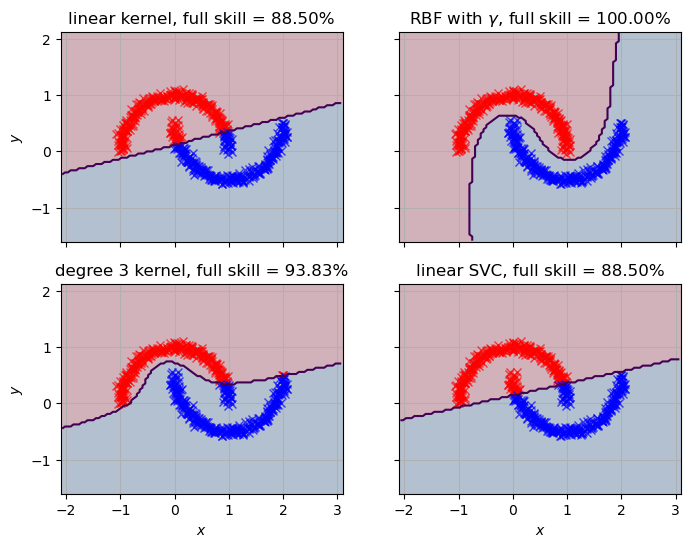

In [11]:
# refresh data

random_state = 0

n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=random_state)

# cycle through an array of models
C = 1.0  # regularisation parameter (1.0 is the default, smaller is larger regularisation)
models = (
    svm.SVC(kernel='linear', C=C, random_state=random_state),
    svm.SVC(kernel='rbf', gamma=0.7, C=C, random_state=random_state),
    svm.SVC(kernel='poly', degree=3, C=C, random_state=random_state),
    svm.LinearSVC(C=C, random_state=random_state),
)
titles = ("linear kernel", r"RBF with $\gamma$", "degree 3 kernel", "linear SVC")

fig = plot_SVM_variants(X, Y, models, titles, C=C);

> <span style="color:red">Q.</span> Try the whole thing again but this time increase the noise in the data generation part (then we won't have a good separation).
>
> <span style="color:red">Q.</span> Try something similar for the swiss roll or S curve data embedded in 3d, with massaging of the data as before.
>
> <span style="color:red">Q.</span> Explore different model parameters to see what that does, and cross-validate things where relevant.

### Things to be aware of: data scaling

SVM is not scale-invariant and can be sensitive to scaling in the data. In the below case I artificially stretch the data in one co-ordinate by quite a large factor, and you can see the data starts behaving a bit strangely (particularly the `rbf` that previously had a 100% accuracy). 

Standardisation is recommended in general (try it for the penguins data later particularly if the `body_mass_g` feature is included, because that has completely different magnitudes compared to the others (and the fact that it doesn't even have comparable units...)

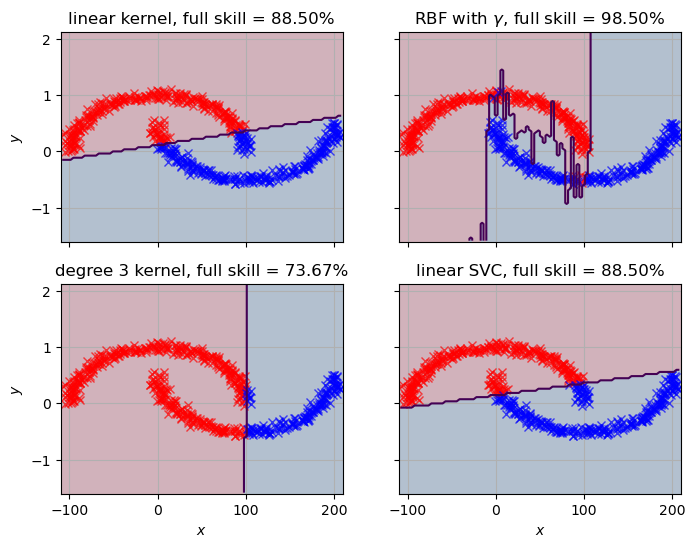

In [12]:
# artificially scaled data
random_state = 0
n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=random_state)

factor = 100
X[:, 0] *= factor  # stretch it in one direction by a factor

fig = plot_SVM_variants(X, Y, models, titles, C=C)

### Things to be aware of: unbalanced datasets

SVM has issues if the dataset is unbalanced, by which I mean there is noticeably more data in one class than the other. In the below code I am going to artificially remove some data from one class and then do SVM on those again.

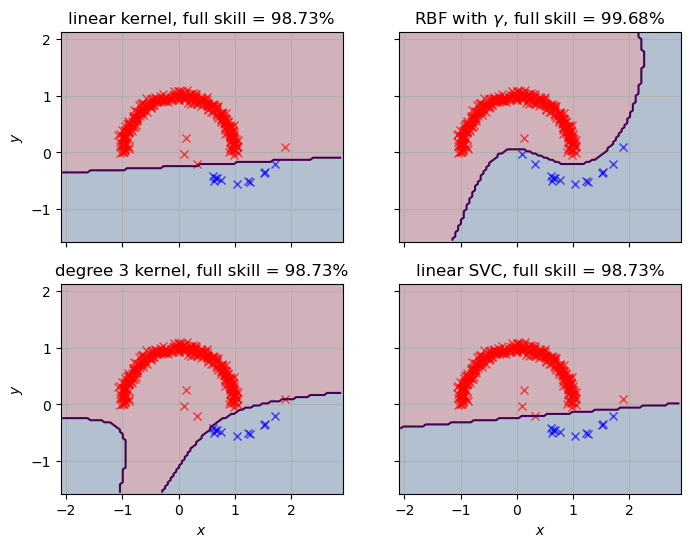

In [13]:
# artifically unbalanced data
random_state = 0
n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=random_state)

# define amount of data to keep, find index, choose an integer selection, and overwrite array
factor = 0.05
inds_full = np.where(Y==1)[0]
np.random.seed(random_state)  # force it to be deterministic
inds = np.random.choice(inds_full, int(factor * len(inds_full)), replace=False)
X = np.concatenate((X[Y==0, :], X[inds, :]), axis=0)
Y = np.concatenate((Y[Y==0], Y[inds]))

fig = plot_SVM_variants(X, Y, models, titles, C=C)

Several possible ways to deal wuth this are (can be used in combination, and not all of them will fix everything):

* remove some data from the larger class (but this is removing data which can be a problem with smaller datasets)
* ***bootstrap*** to bulk out the class that is low on samples (but requires interpolation and/or knowing something about the pdf of the data)
* pass `class_weight="balanced"` when initialising the model
* increase the regularisation `C` when initialising the model (in this case you want to DECREASE the value of `C` though)

Below considers the latter two cases.

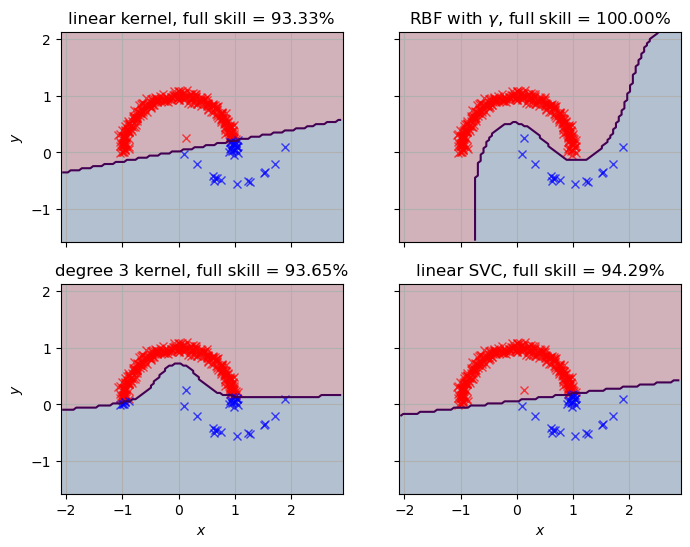

In [14]:
# modifying model parameters for unbalanced dataset
random_state = 0
C = 0.75  # regularisation parameter (1.0 is the default, smaller is larger regularisation)
models = (
    svm.SVC(kernel='linear', C=C, random_state=random_state, class_weight="balanced"),
    svm.SVC(kernel='rbf', gamma=0.7, C=C, random_state=random_state, class_weight="balanced"),
    svm.SVC(kernel='poly', degree=3, C=C, random_state=random_state, class_weight="balanced"),
    svm.LinearSVC(C=C, random_state=random_state, class_weight="balanced"),
)

fig = plot_SVM_variants(X, Y, models, titles, C=C)

The rebalancing seems to improve the SVM using `rbf`, but has marginal response in the other ones.

> <span style="color:red">Q.</span> Try the whole thing again but this time increase the noise in the data generation part (then we won't have a good separation).
>
> <span style="color:red">Q.</span> Try something similar for the swiss roll or S curve data embedded in 3d, with massaging of the data as before.
>
> <span style="color:red">Q.</span> Explore different model parameters to see what that does, and cross-validate things where relevant.

---
## c) Stochastic Gradient Descent (SGD) with different choices of loss and penalisations

So here I want to take a slight detour because some of the details will be relevant to neural networks later. We talked about ***gradient descent*** before as a means to solve the optimisation problem earlier: recally that for the landscape defined by the loss function $J$, around $J(\theta_n)$, you want to probe for the gradient information, and update to get $\theta_{n+1}$ depending on the direction where $J$ descends fastest. Formally to get the full gradient you would need to compute $J$ in some $n$-dimensional ball around $\theta$ to find the optimal direction. 

The idea then is that you could consider some random directions instead of every direction, and use that to approximate for the gradient instead. You potentially take a less direct route to the minimum along the $J$ landscape, but it is cheaper, and you could in principle use the information in the previous iterations to help you along the way. If the number of directions is 1, it's called ***stochastic gradient descent***; if it's more than 1 it's called ***mini-batch*** gradient descent (but also sometimes just labelled as "stochastic"). 

This kind of method is useful particularly for things like neural networks where there are a lot of entries in $\theta$ to adjust, so the dimensionality can be so large that full gradient descent is not computationally feasible. These type of methods also have some suggestion that it can sample the space better to not get stuck in a local minimum.

So SGD itself is a method and not a classifier as such: when you choose the loss function (and appropriate penalisation) you define the type of classifier. For classifiers the kind of loss we want should be one-sided: you should incur a massive cost if you get the classification wrong. Below are some of the these: going to plot these out first before describing them.

> NOTE: You can look through the code to see the mathematical form of these if you want; not going to type those out here... (I basically took the below graph from  [here](https://scikit-learn.org/stable/auto_examples/linear_model/plot_sgd_loss_functions.html), although I renamed the variables.)

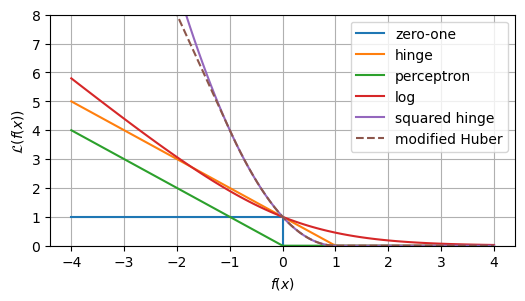

In [15]:
# whole bunch of loss functions

def modified_huber_loss(Y_true, Y_pred):
    z = Y_pred * Y_true
    loss = -4 * z
    loss[z >= -1] = (1 - z[z >= -1]) ** 2
    loss[z >= 1.0] = 0
    return loss

X = np.linspace(-4, 4, 101)

fig = plt.figure(figsize=(6, 3))
ax = plt.axes()
ax.plot([-4, 0, 0, 4], [1, 1, 0, 0], label="zero-one")
ax.plot(X, np.where(X < 1, 1 - X, 0), label="hinge")
ax.plot(X, -np.minimum(X, 0), label="perceptron")
ax.plot(X, np.log2(1 + np.exp(-X)), label="log")
ax.plot(X, np.where(X < 1, 1 - X, 0) ** 2, label="squared hinge")
ax.plot(X, modified_huber_loss(X, 1), "--", label="modified Huber")
ax.set_ylim((0, 8))
ax.legend()
ax.set_xlabel(r"$f(x)$")
ax.set_ylabel(r"$\mathcal{L}(f(x))$")
ax.grid();

We are making the decision here that anything positive is correct, and negative is bad (you can flip these accordingly of course). Respectively, we have:

* zero-one: No cost if correct, other incur a cost of one. This is not really implemented, and is not considered further.
* hinge: It's called "hinge" because it looks like a door hinge (the bit that connects the door to the wall). You start incurring a cost from 1, and this scales up linearly as you get more and more wrong.
* perceptron: It's called "perceptron" because it is used in ***perceptrons***, which we will encounter later when we deal with neural networks. This is like hinge but it starts activating at 0 instead of 1.
* log: Because it follows a (shifted) logarithm. Starts activating sooner but scales up faster than hinge and perceptron (because log blows up to infinity faster than linear functions).
* squared hinge: Because you take the hinge loss function and square it.
* modified Huber: Bit like the squared hinge but is more smooth, has some numerical advantages.

> NOTE: The main reason I wanted to digress into this here is that the loss functions defined here where flipped about the $y$-axis because possible candidates of ***activation functions***, which is important for neural networks later. For example, flipping the perceptron loss above would lead to ***ReLU***, which is usually the default activation for neural networks.

A thing to note here is that the loss functions above are not convex and by itself may not have a minimum. A regularisation is usually needed; common choices are just the $L^1$, $L^2$ and elastic nets (a combination of both).

For a SGD classifer we would import this from `sklearn.linear_model.SGDClassifier`, and passing the keyword `loss=` in. The default regulariser is $L^2$ (`penalty="l2"`). Below are some specific cases:

* `loss="hinge"` and `penalty="l2"` (the default if you just do `SDGClassifier()`: This reduces to linear SVM above.
* `loss="modified_huber"` is a bit like the above, but with punishes outliers more. Comes with probability measures of the decision (cf. allows for `response_method="predict_proba"` in `DecisionBoundaryDisplay.from_estimator`)
* `loss="log_loss"` gives ***Logistic Regression***, which is really a classifier, although it has regression in the name. Sometimes called ***logit*** or ***Maximum Entropy*** classifier; not going to go into why that is.

Below I am just going to one for Logistic Regression.

overall skill: 106 correct out of 120 (88.33%)
 


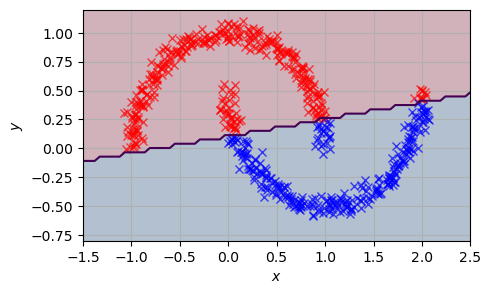

In [16]:
from sklearn.linear_model import SGDClassifier

n_samples = 600
X, Y = make_moons(n_samples, noise=0.05, random_state=0)     # labels are numeric: 0 and 1

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4167)

# fit models
model = SGDClassifier(loss="log_loss")  # just logistic regression, with L2 penalisation
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(" ")

# do a prediction but on full data
Y_pred = model.predict(X)

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for i in range(2):
    ax.plot(X[Y_pred==i, 0], X[Y_pred==i, 1], f"{colors[i]}x", alpha=0.7)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",
    plot_method="pcolormesh",
    ax=ax,
    cmap="RdBu",
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5],  # because the labels are 0 or 1, and (0 + 1)/2 = 0.5
)
ax.set_xlabel(r"$x$"); ax.set_ylabel(r"$y$");
ax.set_xlim([-1.5, 2.5]); ax.set_ylim([-0.8, 1.2])
ax.grid();

> <span style="color:red">Q.</span> You could also do logistic regression via `sklearn.linear_model.LogisticRegression`, and that has somewhat more options (mostly solvers) available. Convince yourself those two more or less do the same things.
>
> <span style="color:red">Q.</span> Try some other combinations (e.g. linear SVM with $L^1$ penalisation, which promotes sparsity). You have to be a bit careful that convergence of the solver may become an issue.
>
> <span style="color:red">Q.</span> One thing of interest to later is the ***learning rate*** that you can specify in the classifier; this is effectively the size of steps the solver takes to iterate towards a minimum. Try the options beyond the default.
>
> This will be a possible model hyper-parameter that one might need to consider for cross-validation and helping for model convergence particularly when we deal with neural networks later.

---
## Demonstration: penguins data

The example here considers doing classification on penguins data (which has three labels). We are going to do the case where there are two features (so I can show decision boundaries), and cases where I throw in all four features.

Recall that in `penguins` the `species` feature is text. We can convert that to numerical values via `sklearn.preprocessing.LabelEncoder`; going to load `StandardScaler` at the same time.

In [17]:
# load the penguin data
option = "remote"

if option == "local":
    print("loading data locally (assumes file has already been downloaded)")
    path = "penguins.csv"
elif option == "remote":
    print("loading data remotely")
    path = "https://raw.githubusercontent.com/julianmak/OCES4303_ML_ocean/refs/heads/main/penguins.csv"
else:
    raise ValueError("INVALID OPTION: use 'remote' or 'local'")

df = pd.read_csv(path)

# choose two particularly different features
feature_names = ["flipper_length_mm", "body_mass_g"]
X = df[feature_names].values

from sklearn.preprocessing import LabelEncoder, StandardScaler

# turn target from text to numerical values
encoder = LabelEncoder()
Y = encoder.fit_transform(df["species"])

print(f"{encoder.classes_} mapped to {encoder.transform(encoder.classes_)}")
print(" ")

loading data remotely
['Adelie' 'Chinstrap' 'Gentoo'] mapped to [0 1 2]
 


I am going to do this wrong first by using `SVM` but not scaling the data.

overall skill: 54 correct out of 69 (78.26%)


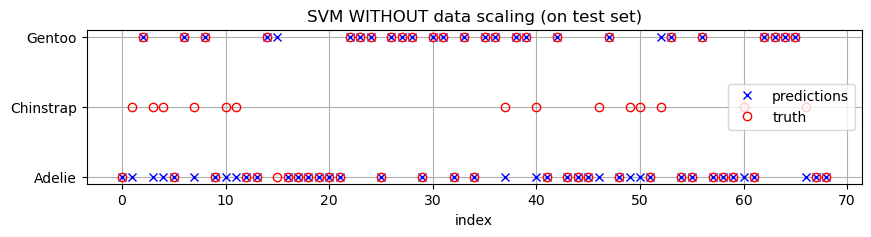

In [18]:
# withhold 20% of data that model training does not see, and use that to test skill
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4167)

# fit a model
model = svm.SVC()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")

# plot out the predictions (circles should lie on top of crosses if completely correct)
fig = plt.figure(figsize=(10, 2))
ax = plt.axes()
ax.plot(Y_pred, 'bx', label="predictions")
ax.plot(Y_test, 'ro', fillstyle="none", label="truth")
ax.set_xlabel("index")
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(encoder.classes_)
ax.set_title(r"SVM WITHOUT data scaling (on test set)")
ax.legend()
ax.grid();

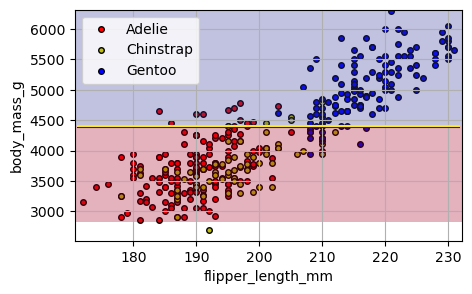

In [19]:
# do a prediction but on full data
Y_pred = model.predict(X)

colors = "ryb"  # red yellow blue

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for j in range(3): # 3 species
    idx = np.where(Y == j)
    ax.scatter(X[idx, 0], X[idx, 1], c=colors[j], edgecolor="k", 
               s=16, label=encoder.classes_[j])
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",
    plot_method="pcolormesh",
    ax=ax,
    cmap=plt.cm.RdYlBu,
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X_train,
    response_method="predict",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5, 1.5],  # because the labels are 0 1 2
)
ax.set_xlabel(f"{feature_names[0]}"); ax.set_ylabel(f"{feature_names[1]}");
ax.grid()
ax.legend();

So somehow it finds a boundary for `Chinstraps` to be absolutely tiny to the point it basically doesn't exist, so it makes no predictions for it. Lets see what happens if we standardise the data.

overall skill: 54 correct out of 69 (78.26%)
 


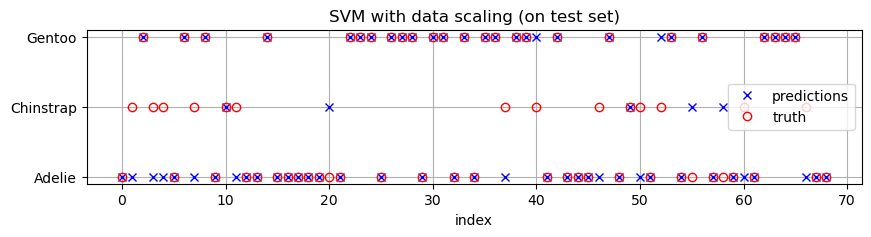

In [20]:
# standardise data X the proceed as usual

X = df[feature_names].values
X = StandardScaler().fit_transform(X) # don't need to do Y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4167)

# fit a model
model = svm.SVC()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(" ")

# plot out the predictions (circles should lie on top of crosses if completely correct)
fig = plt.figure(figsize=(10, 2))
ax = plt.axes()
ax.plot(Y_pred, 'bx', label="predictions")
ax.plot(Y_test, 'ro', fillstyle="none", label="truth")
ax.set_xlabel("index")
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(encoder.classes_)
ax.set_title(r"SVM with data scaling (on test set)")
ax.legend()
ax.grid();

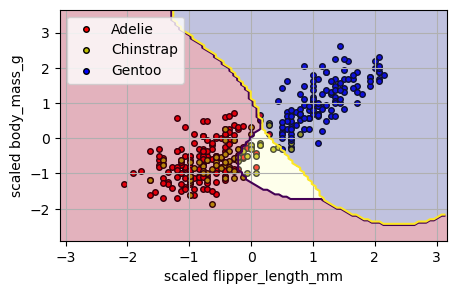

In [21]:
# do a prediction but on SCALED full data
Y_pred = model.predict(X)

colors = "ryb"  # red yellow blue

fig = plt.figure(figsize=(5, 3))
ax = plt.axes()
for j in range(3): # 3 species
    idx = np.where(Y == j)
    ax.scatter(X[idx, 0], X[idx, 1], c=colors[j], edgecolor="k",
               s=16, label=encoder.classes_[j])
DecisionBoundaryDisplay.from_estimator(model, X,
    response_method="predict",
    plot_method="pcolormesh",
    ax=ax,
    cmap=plt.cm.RdYlBu,
    alpha=0.3,
)
DecisionBoundaryDisplay.from_estimator(model, X,
    response_method="predict",
    plot_method="contour",
    ax=ax,
    alpha=1.0,
    levels=[0.5, 1.5],  # because the labels are 0 1 2
)
ax.set_xlabel(f"scaled {feature_names[0]}"); ax.set_ylabel(f"scaled {feature_names[1]}");
ax.grid()
ax.legend();

So here it is at least the separators are carving out a region for predicting `Chinstraps`, although the accuracy is not that high.

What if we throw all the data in? We can evalute the scores although we can't really plot the bondaries anymore.

overall skill: 68 correct out of 69 (98.55%)
 


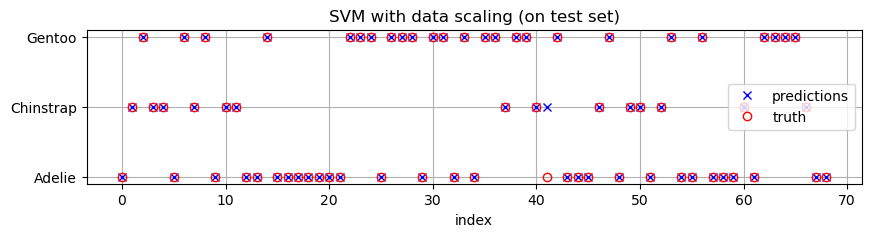

In [22]:
# as above but for all features
feature_names = ["bill_length_mm", "bill_depth_mm", "flipper_length_mm", "body_mass_g"]
X = df[feature_names].values
X = StandardScaler().fit_transform(X) # don't need to do Y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=4167)

# fit a model
model = svm.SVC()
model.fit(X_train, Y_train)

# basic skill diagnostics
Y_pred = model.predict(X_test)
N = len(Y_test)
skill_all = np.sum(Y_pred == Y_test)
print(f"overall skill: {skill_all} correct out of {N} ({skill_all/N*100:.2f}%)")
print(" ")

# plot out the predictions (circles should lie on top of crosses if completely correct)
fig = plt.figure(figsize=(10, 2))
ax = plt.axes()
ax.plot(Y_pred, 'bx', label="predictions")
ax.plot(Y_test, 'ro', fillstyle="none", label="truth")
ax.set_xlabel("index")
ax.set_yticks([0, 1, 2])
ax.set_yticklabels(encoder.classes_)
ax.set_title(r"SVM with data scaling (on test set)")
ax.legend()
ax.grid();

> <span style="color:red">Q.</span> There is something to be said about decreasing the complexity by minimising the number of features. Consider keep the number of input features at two, but see which combination gives the best score.
>
> <span style="color:red">Q.</span> As above, but what if you do dimension reduction techniques on it first?
> 
> <span style="color:red">Q.</span> Try other options under SVM, and/or types of classifers (with various options).
>
> <span style="color:red">Q.</span> Do robustness tests and cross-validation accordingly.

----------------
# More involved exercises with this notebook

## 1) Other classifiers

There are other classifiers I didn't go through because they either follow the same principles we have encountered before, or they are completely different (e.g. dealing quite a bit with probability). These include:

* Ridge classification ($L^2$ penalisation as in linear models; can also do regression)
* Logistic classification (it's called `LogisticRegression` in `sklearn` though; it is part of `linear_model`, and is a special case of Generalised Linear Models)
* Nearest Neighbours (somewhat related to clustering things we have seen; can also do regression)
* Gaussian Processes (probabilistic classifiers; can also do regression)
* Naive Bayes and its extensions (as above)

Have a look at some of these.

(I personally think the Gaussian Processes and Bayesian approaches are the most interesting, because they can provide soft boundaries and measures of uncertainty. I guess just using them is fine, but understanding what they do with take a bit more work.)

## 2) Classifying cats and dogs

#### (This one is related to the upcoming assignment.) 

Try and do cats and dogs classification. You may or may not want to use dimension reduction approaches first.

You may also want to revisit again after all the subsequent lectures (decision trees, random forests, neural networks), because it's a hard test in general.

## 3) More with SVM

You can use `svm.SVR` for doing regression, try that with some previous examples encountered.

There are also other variants of SVM (`NuSVC` and `NuSVR`), have a look and see what those are, apply them to some examples considered here and see how the results compare accordingly.

## 4) Regression

You can do regression with the SGD stuff too. Have a look on the manual on what kind of loss functions you can use etc. and apply them to some examples considered here or previously also (e.g. penguins data, time series forecasting with `elnino34_sst.data`, Lotka-Volterra, Lorenz, or similar).